## Flood Risk Reduction Evaluation and Screening

<p><b>FLORES</b> is a fast flood risk screening model, aimed at providing useful information early in the decision-making process for flood-prone cities. It simulates and evaluates the impact of many alternative flood risk reduction strategies, each consisting of a combination of measures.Basic formulas are used instead of more complex hydraulic modelling software, to reduce computation time, and to allow the model to run on a personal computer.</p> 

<p> 
<ul style="list-style-type: circle;">
<li><b>Multiple flood hazards;</b> Considers multiple flood hazards: coastal flooding, river flooding, and urban flooding. Also storms can be simulated that compound the effects of multiple hazards,</li>
<li><b>Combining structural and non-structural measures;</b> The FLORES model takes various methods of reducing flood risk into account. Including: coastal protection, storm surge barriers, drainage, retention, urban planning, early warning systems,</li>
<li><b>Multiple performance metrics for comparison;</b> As most decisions are not made solely based on economic arguments, flood risk reduction strategies are assessed based on multiple parameters,</li>
<li><b>Multi-purpose evaluation techniques;</b> Early in design, many stakeholders are involved. A wide range of different analysis tools is available, in order to tailor the type of analysis to the specific needs of the user. This can range from finding correlations and trade-offs, to scenario discovery or more sophisticated robust decision making tools. These tools are provided through the use of the EMA-workbench (Kwakkel, 2017),</li>
<li><b>Limited data requirements;</b> Many flood-prone cities are located in regions that lack reliable data. The model focusses on the conceptual design phase, where detailed results are not expected yet. Therefore, it is built to work with widely-available (open) data sets.</li>
<li><b>Generic setup;</b> The FLORES model aims to be used in a wide variety of situations and areas. It is therefore developed as a generic model, consisting of separate modules, where no additional coding is required. The model only requires processing of the local characteristics, partly by using GIS-tools.</li>  
</ul>
</p>

<p> The FLORES model has been developed at Delft University of Technology, Department of Hydraulic Engineering, in cooperation with GFDRR and the World Bank Group <b>(van Berchum, 2019)</b>. Parts of the model have been developed in previous research, in cooperation with Texas A&M University Galveston <b>(van Berchum and Mobley, 2017)</b></p>

<p> This notebook runs through the entire model, including installation, input data, simulation, and several analyses. It requires no previous installation, besides Python 3 and Jupyter Notebook. Throughout the walkthrough, multiple packages will be downloaded, most notably the EMA-workbench.</p>

<p>Version FLORES model: 0.3 (first generic version)<br/>
    Version EMA-workbench: 2.1</p>

Last Updated: 29-11-2019


## 1. Download and installation model

<p>Here, we download the main model components:<br/><br/>
FLORES, available on Github <br/>
EMA-workbench, available on pip <br/></p>

<p>build correct folder structure for analysis:<br/>    
<ul style="list-style-type: circle;">
<li>data,</li> 
<li>figs,</li>  
<li>Library,(input data folder, FLORES python files)</li>  
<li>analysis notebook,</li>  
<li>runner notebook</li> 
</ul></p>


In [20]:
#from __future__ import (absolute_import, division, print_function, unicode_literals)
from pathlib import Path
import os
import sys

# never use absolute paths that are system specific unless you 
# realy have no other choice
sys.path.append(os.path.abspath('..'))
from matplotlib import pyplot
        
    
from ema_workbench import (CategoricalParameter, RealParameter, ScalarOutcome, Constant,
                           ReplicatorModel, ema_logging, MultiprocessingEvaluator, 
                           save_results)
from FLORES_tools.Library.flood_simulation_model import (FloodSimModel, process_risk, pick_one, process_affected_people, SimulationInput)

from datetime import date
from timeit import default_timer as timer


path_src = os.path.abspath('..')
print(path_src)  

D:\GitHub\FLORES-Beira\src


## 2. Import model parts for analysis

- import all ema-workbench files needed for analysis
- import all other packages needed for analysis

## 3. Import case study data

- make a choice in which DEM to use
- show DEM, basin strucure, layers structure
- import .csv files of basins, layers
- show+import measures data
- show+import all storm data
- show+import damage curves
- show+import drainage data


In [2]:
dir_name_data = os.path.join(path_src, 'Projects/FLORES_beira/input_data').replace('\\','/')
print(dir_name_data)
flores_sim = FloodSimModel()

D:/GitHub/FLORES-Beira/src/Projects/FLORES_beira/input_data


In [3]:
# Make choice for DEM
flores_dem = 'TanDEM'
suffix_dem = '.PNG'
dem_folderpath = os.path.join(dir_name_data, 'schematization/', flores_dem).replace('\\','/')
dem_plotfile = str(os.path.join(dem_folderpath, flores_dem + suffix_dem)).replace('\\','/')
dem_datafolder = os.path.join(dem_folderpath, 'data').replace('\\','/')


### City schematization

<p>GIS-based computations are often computationally very demanding. Therefore, the area will be schematized to speed up the simulation. Within the FLORES model, the city will be schematized as a number of <b>drainage basins</b>. A drainage basin is defined as the area where water drains towards the same location, i.e. the lowest point in that specific area. This way, the local topography of the city, with local depressions, is accounted for. The hydraulic simulation of a storm and/or rainfall event revolves around the (connected) volume balances of these drainage basins. This type of simulation has many similarities with other Rapid Flood Inundation Models (RFIM) as proposed by Shen et al. (2016), Liu and Pender (2010) and Lhomme et al. (2008). In the FLORES Flood simulation, this volume balance is expanded by taking into account rainfall, infiltration, drainage, retention and surface flow between drainage basins.</p>

<p>Moreover, when a city is also threatened by storm surge, <b>lines of defense</b> (e.g. coastline, riverbank) are also defined and the water flowing across such a line of defense is modelled as inflow for the affected drainage basins. This volume balance will be repeated for each basin and for every timestep throughout the flood event.</p>

In [4]:
# Show schematization
suffix_plot = '.PNG'
suffix_data = '.csv'
basin_plotfile = str(os.path.join(dem_folderpath, flores_dem + '_basins' + suffix_plot)).replace('\\','/')
LOD_plotfile = str(os.path.join(dem_folderpath, flores_dem + '_lines_of_defense' + suffix_plot)).replace('\\','/')
basin_datafile = str(os.path.join(dem_datafolder, flores_dem + '_basins' + suffix_data)).replace('\\','/')
LOD_datafile = str(os.path.join(dem_datafolder, flores_dem + '_lines_of_defense' + suffix_data)).replace('\\','/')
basin_borders_datafile = str(os.path.join(dem_datafolder, flores_dem + '_basin_borders' + suffix_data)).replace('\\','/')
basin_drainage_datafile = str(os.path.join(dem_datafolder, flores_dem + '_basin_drainage' + suffix_data)).replace('\\','/')
flores_sim.save_source('basins', basin_datafile)
flores_sim.save_source('layers', LOD_datafile)
flores_sim.save_source('basin_borders', basin_borders_datafile)
flores_sim.save_source('basin_drainage', basin_drainage_datafile, 'yes')

## Exposure

<p>The impact calculation is based on people and structures exposed to inundation caused by the storm. There is spatial data available on population and structural value. By combining this data with the DEM, csv-datafiles are built containing population numbers and structural value for individual drainage basins, and for different elevation levels within. 
</p>

In [5]:
pop_source = 'ADFR_pop'
str_source = 'ADFR_str'
folder_exposure = 'exposure'
suffix_plot = '.tif'
suffix_data = '.csv'
exposure_folderpath = os.path.join(dem_datafolder, folder_exposure).replace('\\','/')
pop_folder = os.path.join(exposure_folderpath,pop_source).replace('\\','/')
str_folder = os.path.join(exposure_folderpath, str_source).replace('\\','/')
pop_plotfile = str(os.path.join(pop_folder, pop_source + suffix_plot)).replace('\\','/')
structures_plotfile = str(os.path.join(str_folder, str_source + '.png')).replace('\\','/')
pop_datafile = str(os.path.join(pop_folder, pop_source + suffix_data)).replace('\\','/')
str_datafile = str(os.path.join(str_folder, str_source + suffix_data)).replace('\\','/')
flores_sim.save_source('population', pop_datafile)
flores_sim.save_source('structures', str_datafile, 'yes')

<p> The damage to exposed structures is measured with the use of <b> damage curves</b>. These curves give the amount of damage as a result of a given inundation depth. damage curves are available for different land use types. Please note that these figures are used to calculate the expected value of structural damage. The amount of people affected uses a simplified definition, where a person is 'affected' when the water level in the residence rises above 10 cm.
</p>

In [6]:
dam_curve_source = "damage_curves_JRC"
suffix_dam_curve = ".xlsx"
dam_curve_file = str(os.path.join(dir_name_data, 'schematization/' + dam_curve_source + suffix_dam_curve)).replace('\\','/')
flores_sim.save_source('damage_curves', dam_curve_file, 'yes')
print(dam_curve_file)


D:/GitHub/FLORES-Beira/src/Projects/FLORES_beira/input_data/schematization/damage_curves_JRC.xlsx


## Flood risk reduction measures

<p> A flood risk reduction strategy consists of a combination of potential measures. In order to represent the full array of options for flood risk management, many different types of measures are included. Measures can affect different parts of the model. </p>

<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 5px;
  text-align: left;    
}
</style>
</head>
<body>

<table style="width:100%">
  <tr>
    <th>Type</th>
    <th>Measure</th>
    <th>Location</th>
    <th>Costs</th>
    <th>Remarks</th>
  </tr>
  <tr>
    <td rowspan="4">Coastal structures</td>
    <td>Coastal dike - East</td>
    <td>Eastern coast</td>
    <td>2 million USD</td>
    <td>Possible heights: 7.0;7.5;8.0;8.5;9.0;9.5 m</td>
  </tr>
  <tr>
    <td>Coastal dike - West</td>
    <td>Western coast</td>
    <td>4 million USD</td>
  </tr>
  <tr>
    <td>Coastal dunes - East</td>
    <td>Eastern coast</td>
    <td>4 million USD</td>
  </tr>
  <tr>
    <td>Floodwall - West</td>
    <td>Western coast</td>
    <td>4 million USD</td>
  </tr>
  <tr>
      <td rowspan="2">Coastal dike - West</td>
      <td>Western coast</td>
      <td>4 million USD</td>
    </tr>
  <tr>
      <td>Coastal dike - West</td>
      <td>Western coast</td>
      <td>4 million USD</td>
    </tr>
</table>



First, we will run a single simulation to look at its effects. Therefore, it is necessary to choose a strategy, consisting of a combination of flood risk reduction measures. Below, all locations where measures can be placed are listed. The options are listed at the appropriate location and correspond to the measures in the table above.

In [7]:
measures_source = 'flood_risk_reduction_measures_'
suffix_measures_data = '.csv'
measures_datafile = str(os.path.join(dir_name_data,'measures/' + measures_source + flores_dem + suffix_measures_data)).replace('\\','/')
flores_sim.save_source('measures', measures_datafile, 'yes')

flores_sim.define_active_measures(CD_1=True,
                                  CD_2=True,
                                  CD_3=True,
                                  CD_4=True,
                                  SM_1=True,
                                  DR_1=True,
                                  DR_2=True,
                                  RT_1=True,
                                  RT_2=True,
                                  EM_1=True,
                                  EM_2=True
                                  )



## Import storm data

<p>
The simulation is centered around the effects of an incoming storm. In the current FLORES model, it is possible to take into account the effects of <b>coastal storm surge</b> and <b>extreme rainfall</b>. These hazards can occur separately or together, as would be the case during a cyclone event. The severity of the storm is measured in the return period of the underlying hazard. For example, a cyclone can lead to 100-year storm surge and a 10-year rainfall event.</p>

<p> Coastal storm surge is simulated in the form of a time series of water levels along the coast. All transitioning from deep sea to nearshore conditions is done beforehand. The length of the storm can vary. As time series of storms are often scarse, time series of historic events are scaled, depending on the highest reached water levels.</p>

<p>Rainfall is much more random to simulate, as each rainfall event can show a totally different time series of rainfall intensity. It is therefore unnecessary and unrealistic to base time series on past events, which is why a constant time series will be used. When no information is available about local hotspots that receive significantly higher amounts of rainfall, the spatial distribution is also constant. </p> 

<p>By choosing a source and plotting the result, you can see the rainfall duration-intensity curves and the 100 year storm surge time series.</p>


In [8]:
rain_source = 'study_chiveve'
ss_source = 'SS'
folder_hazard = 'hazards'
suffix_plot = '.jpg'
suffix_data = '.csv'
hazard_folderpath = os.path.join(dir_name_data, folder_hazard).replace('\\','/')
rain_plotfile = str(os.path.join(hazard_folderpath,'rainfall_' + rain_source + suffix_plot)).replace('\\','/')
ss_plotfile = str(os.path.join(hazard_folderpath, 'surge_' + ss_source + suffix_plot)).replace('\\','/')
rain_datafile = str(os.path.join(hazard_folderpath, 'rainfall_' + rain_source + suffix_data)).replace('\\','/')
ss_datafile = str(os.path.join(hazard_folderpath, 'surge_' + ss_source + suffix_data)).replace('\\','/')

flores_sim.save_source('hazard_rain', rain_datafile)
flores_sim.save_source('hazard_surge', ss_datafile, 'yes')

## Future scenarios

<p>The change of a city over time can greatly affect the impact of implementing flood risk reduction measures. Likewise, changes to hazard intensity - due to climate change - can greatly change the situation. It is therefore crucial to look at flood risk reduction in the context of changing circumstances and a changing city. Looking at all possible futures, in order to find the strategy that fits all possible futures, is at the heart of <b> Robust Decision Making</b>. With the use of the screening tool and analysis tools provided by the EMA-workbench, it is possible to pursue robust solutions.</p>

<p>In this case study, only the effects of climate change can be altered, in order to see its effect on the risk profile. Urban development is also added to the model. However, because it is connected to land use types, which don't very much throughout the city, varying the urban development predictions provides no new information.</p>

In [9]:
climate_source = 'IPCC'
urban_source = 'GOV'
folder_scenarios = 'scenarios'
suffix_scenarios_data = '.csv'
scenarios_folderpath = os.path.join(dir_name_data, folder_scenarios).replace('\\','/')
climate_scenarios_data = str(os.path.join(scenarios_folderpath,'climate_' + climate_source + suffix_scenarios_data)).replace('\\','/')
urban_scenarios_data = str(os.path.join(scenarios_folderpath, 'urban_dev_' + urban_source + suffix_scenarios_data)).replace('\\','/')
flores_sim.save_source('climate_scenarios', climate_scenarios_data)
flores_sim.save_source('urban_development_scenarios', urban_scenarios_data, 'yes')

All sources defined. Importing datasets.


## 4 Screen flood risk reduction stategies

- make choice on number of storms to use, which measures to compare, how many strategies to compare
- Run model


In [10]:
ema_logging.log_to_stderr(level=ema_logging.INFO)
flores_screen = ReplicatorModel('Beira', function=flores_sim.screening_simulation_model)

flores_screen.replications = [{"return_period_rainfall": 100, "return_period_storm_surge": 100},
                                {"return_period_rainfall": 50, "return_period_storm_surge": 100},
                                {"return_period_rainfall": 10, "return_period_storm_surge": 100},
                                {"return_period_rainfall": 5, "return_period_storm_surge": 100},
                                {"return_period_rainfall": 0, "return_period_storm_surge": 100},
                                {"return_period_rainfall": 100, "return_period_storm_surge": 50},
                                {"return_period_rainfall": 50, "return_period_storm_surge": 50},
                                {"return_period_rainfall": 10, "return_period_storm_surge": 50},
                                {"return_period_rainfall": 5, "return_period_storm_surge": 50},
                                {"return_period_rainfall": 0, "return_period_storm_surge": 50},
                                {"return_period_rainfall": 100, "return_period_storm_surge": 10},
                                {"return_period_rainfall": 50, "return_period_storm_surge": 10},
                                {"return_period_rainfall": 10, "return_period_storm_surge": 10},
                                {"return_period_rainfall": 5, "return_period_storm_surge": 10},
                                {"return_period_rainfall": 0, "return_period_storm_surge": 10},
                                {"return_period_rainfall": 100, "return_period_storm_surge": 5},
                                {"return_period_rainfall": 50, "return_period_storm_surge": 5},
                                {"return_period_rainfall": 10, "return_period_storm_surge": 5},
                                {"return_period_rainfall": 5, "return_period_storm_surge": 5},
                                {"return_period_rainfall": 0, "return_period_storm_surge": 5},
                                {"return_period_rainfall": 100, "return_period_storm_surge": 0},
                                {"return_period_rainfall": 50, "return_period_storm_surge": 0},
                                {"return_period_rainfall": 10, "return_period_storm_surge": 0},
                                {"return_period_rainfall": 5, "return_period_storm_surge": 0},
                                {"return_period_rainfall": 'INFO', "return_period_storm_surge": 'INFO'}]


leverlist = []
structural_measures = {}
structural_locations = {}
for measure in flores_sim.AllMeasures:
    if flores_sim.AllMeasures[measure].Type == 'Structural':
        structural_measures[measure] = flores_sim.AllMeasures[measure].Location
    else:
        leverlist.append(CategoricalParameter(measure, [True, False]))
    
for measure, location in structural_measures.items():
    if location not in structural_locations:
        structural_locations[location] = [measure]
    else:
        structural_locations[location].append(measure)
        
for location in structural_locations:
    structural_locations[location].append('none')
    leverlist.append(CategoricalParameter('structure-' + location,  structural_locations[location]))
    first_measure = structural_locations[location][0]
    leverlist.append(RealParameter('height-' + location, flores_sim.AllMeasures[first_measure].StructureHeights[0],
                                   flores_sim.AllMeasures[first_measure].StructureHeights[-1]))



flores_screen.levers = leverlist

flores_screen.constants = [Constant('urban_development_scenario', 'low')]

flores_screen.uncertainties = [CategoricalParameter('climate_scenario', ['low', 'high'])]

flores_screen.outcomes = [ScalarOutcome("risk_reduction", function=process_risk),
                            ScalarOutcome("construction_costs", function=pick_one),
                            ScalarOutcome("affected_pop_reduction", function=process_affected_people)]

nr_strategies = 500

today = date.today()


fn = ('Projects/FLORES_beira/data/{0} experiments_FLORES_{1}_{2}_tandem_trapz.tar.gz'.format(nr_strategies, 'Beira', today))
print('ready for screening')

ready for screening


### run screening
*warning, this may take several hours to run. If you want to analyze a previous screening, skip this block*

In [ ]:
path_fn = os.path.join(path_src, fn).replace('\\','/')
print(path_fn)
if not os.path.exists(path_fn):
    
    start = timer()
    #with SequentialEvaluator(flores_screen) as evaluator:
    with MultiprocessingEvaluator(flores_screen, n_processes=8) as evaluator:
        results = evaluator.perform_experiments(scenarios=2, policies=nr_strategies,
                                                uncertainty_sampling='ff', reporting_interval=1)
    save_results(results, path_fn)
    print("done")
    end = timer()
    print(end - start)

D:/GitHub/FLORES-Beira/src/Projects/FLORES_beira/data/500 experiments_FLORES_Beira_2019-11-29_tandem_trapz.tar.gz


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2 scenarios * 500 policies * 1 model(s) = 1000 experiments


# 5 Flood Risk Analysis

<p>With the use of the screening tool, many flood risk reduction strategies have been simulated. Next, we will use a selection of tools to analyze the results.</p>

<p>First, we will list all previous screening runs. If you want to view the results, copy the string into the code cell below at: <br>
    <br>
    str_path_results = str(data_directory.joinpath(*insert string here*))</p>

In [15]:
from os import listdir

data_directory = os.path.join(path_src, 'Projects/FLORES_beira/data').replace('\\','/')
listdir(data_directory)

['500 experiments_FLORES_Beira_2019-11-25_lidar.tar.gz',
 '500 experiments_FLORES_Beira_2019-11-29_tandem.tar.gz']

In [18]:
from ema_workbench import load_results
path_results = os.path.join(data_directory,'500 experiments_FLORES_Beira_2019-11-25_lidar.tar.gz')
results = load_results(path_results)
experiments, outcomes = results
print(experiments.shape)
print(list(outcomes.keys()))

[MainProcess/INFO] results loaded succesfully from D:\GitHub\FLORES-Beira\src\Projects\FLORES_beira\data\500 experiments_FLORES_Beira_2019-11-25_lidar.tar.gz


(1000, 20)
['risk_reduction', 'construction_costs', 'affected_pop_reduction']


[MainProcess/INFO] no time dimension found in results


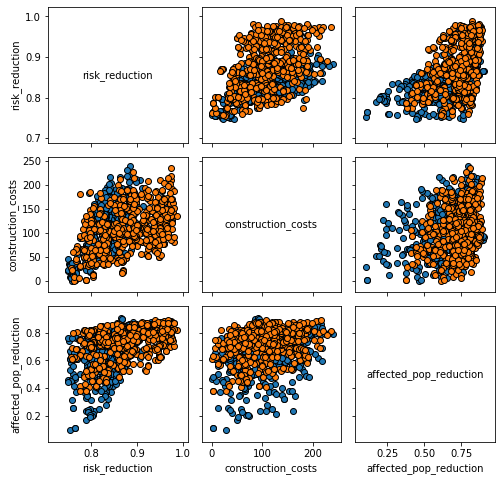

In [23]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='climate_scenario', 
                                         legend=False)
fig.set_size_inches(8,8)
pyplot.show()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


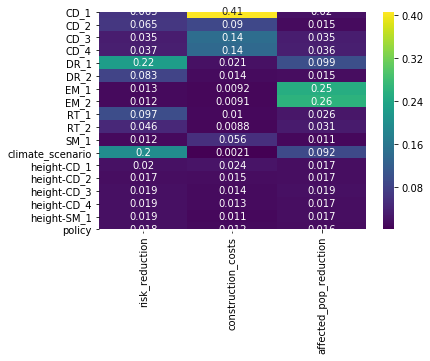

In [24]:
#import numpy.lib.recfunctions as rf
from ema_workbench.analysis import feature_scoring
import seaborn as sns
#results_update = results.where((pd.notnull(results)),'none')

#experiments = rf.drop_fields(experiments, ['policy'], asrecarray=True)

x = experiments
y = outcomes

# focus dataset on 1 climate scenario
#x_bool = x[x_bool==1]
#y_new = y[x_bool==1]

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
pyplot.show()

In [ ]:
from ema_workbench.analysis import prim
b1= outcomes['risk_reduction'] > 0.40
b2= outcomes['construction_costs'] < 125
b3= outcomes['affected_pop_reduction'] > 0.65
b4= x['climate_scenario'] == 'low'

y = b1 & b2 & b3 &b4

prim_alg = prim.Prim(x,y, threshold=0.7)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 1000 points remaining, containing 243 cases of interest


In [ ]:
box1.show_tradeoff()
pyplot.show()

In [ ]:
box1.show_pairs_scatter()
pyplot.show()